Classification Report:
                     precision    recall  f1-score   support

Left-arm unorthodox       0.66      1.00      0.80       862
    Left-arm-googly       0.00      0.00      0.00       443

           accuracy                           0.66      1305
          macro avg       0.33      0.50      0.40      1305
       weighted avg       0.44      0.66      0.53      1305



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


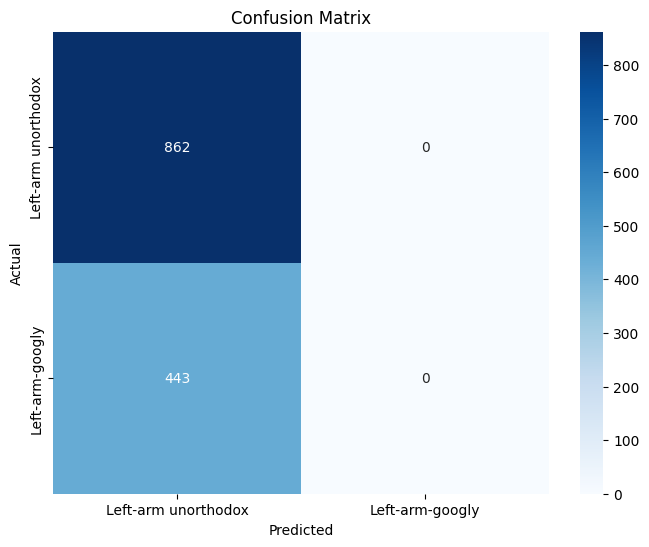

In [11]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract frames and labels from the dataset
def extract_frames_and_labels(dataset_path):
    categories = ["Left-arm unorthodox", "Left-arm-googly"]
    frames, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for video_file in os.listdir(category_path):
            video_path = os.path.join(category_path, video_file)
            cap = cv2.VideoCapture(video_path)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
                labels.append(label)
            cap.release()
    return frames, labels

# Load the dataset
frames, labels = extract_frames_and_labels("/kaggle/input/spin-ball")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(frames, labels, test_size=0.2, random_state=42)

# Load YOLO model
def load_yolo_model(weights_path, config_path):
    net = cv2.dnn.readNet(weights_path, config_path)
    return net

# Predict using YOLO model
def predict_with_yolo(net, frames):
    y_pred = []
    for frame in frames:
        height, width = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outputs = net.forward(net.getUnconnectedOutLayersNames())
        
        boxes, confidences, class_ids = [], [], []
        for output in outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:  # Adjust confidence threshold as needed
                    center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')
                    x = int(center_x - (w / 2))
                    y = int(center_y - (h / 2))
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Assuming binary classification: 0 or 1
        if len(class_ids) > 0:
            y_pred.append(max(set(class_ids), key=class_ids.count))  # Most frequent class_id
        else:
            y_pred.append(0)  # Default to 0 if no detections

    return np.array(y_pred)

# Load YOLO model weights and config
yolo_net = load_yolo_model("/kaggle/input/images/other/default/1/yolov3.weights", 
                            "/kaggle/input/images/other/default/1/yolov3.cfg")

# Use YOLO to predict on test frames
y_pred = predict_with_yolo(yolo_net, X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Left-arm unorthodox", "Left-arm-googly"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Left-arm unorthodox", "Left-arm-googly"],
            yticklabels=["Left-arm unorthodox", "Left-arm-googly"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Plotting accuracy over epochs can be done if you have the history data during training
# (This part would need to be added based on your training loop)

